<a href="https://colab.research.google.com/github/Aldistwn29/ProjectDS/blob/main/Clustring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retail Rationalization Business Clustring

Store Rationalization adalah reorganisasi perusahaan untuk meningkatkan efisiensi operasi dan mengurangi biaya. Akibat krisis Covid-19, beberapa bisnis retail dari seluruh dunia tutup toko. Itu bukan semata-mata gejala financial distress, bahkan banyak perusahaan yang memfokuskan investasinya untuk membuat bisnisnya lebih digital.

Kita akan menggunakan "set data Starbucks Stores" yang menyediakan lokasi semua toko yang beroperasi. Kita akan memilih area geografis tertentu dan, selain garis lintang dan garis bujur yang disediakan, kita akan mensimulasikan beberapa informasi bisnis untuk setiap toko dalam kumpulan data (biaya, kapasitas, staf).

Secara khusus, kita akan melalui:

* Setup: paket impor, membaca data geografis, membuat fitur bisnis.
* Analisis Data: penyajian kasus bisnis di peta dengan folium dan geopy.
* Clustering: Machine Learning (K-Means) dengan scikit-learn,
Store Rationalization: membangun algoritma deterministik untuk menyelesaikan kasus bisnis.

In [1]:
# for data
import numpy as np
import pandas as pd

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for geospatial
import folium
import geopy

# for machine learning
from sklearn import preprocessing, cluster
import scipy

In [2]:
dtf = pd.read_csv('https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_stores.csv')
dtf.columns.tolist()

['Brand',
 'Store Number',
 'Store Name',
 'Ownership Type',
 'Street Address',
 'City',
 'State/Province',
 'Country',
 'Postcode',
 'Phone Number',
 'Timezone',
 'Longitude',
 'Latitude']

In [29]:
filter = 'Las Vegas'
dtf = dtf[dtf["City"]==filter][["City", "Street Address", "Longitude", "Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


Di kawasan itu, ada 156 toko. Untuk melanjutkan kasus bisnis, kita akan mensimulasikan beberapa informasi untuk setiap toko:

* Potensi: total kapasitas dalam hal staf (misalnya 10 berarti toko dapat memiliki hingga 10 karyawan)
* Staf: tingkat staf saat ini (misalnya 7 berarti toko saat ini beroperasi dengan 7 karyawan)
* Kapasitas: kapasitas kiri saat ini (misalnya 10–7=3, toko masih dapat menampung 3 karyawan)
* Biaya: biaya tahunan bagi perusahaan untuk menjaga agar toko tetap beroperasi (“rendah”, “sedang”, “tinggi”)

In [124]:
dtf["Potential"] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf["Staff"] = dtf["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
dtf["Capacity"] = dtf["Potential"] - dtf["Staff"]
dtf["Cost"] = np.random.choice(["high","medium","low"], size=len(dtf), p=[0.4,0.5,0.1])
dtf.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,CapaCity,Cost,cluster,centroids,controids,Capacity
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,6,5,3,high,3,0,0,1
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,8,4,6,medium,0,0,0,4
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,4,4,2,medium,3,0,0,0
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,5,1,5,high,1,0,0,4
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,3,3,2,high,3,1,0,0


Harap dicatat bahwa ini hanya simulasi, angka-angka ini dihasilkan secara acak dan tidak benar-benar mencerminkan bisnis Starbucks (atau perusahaan lain mana pun).

Sekarang semuanya sudah siap, kita akan mulai dengan menganalisis kasus bisnis, kemudian membangun model pengelompokan dan algoritma rasionalisasi.

Mari kita mulai, ya?

# EDA

Anggap saja kita memiliki bisnis ritel dan kita harus menutup beberapa toko. Kita ingin melakukan itu dengan memaksimalkan keuntungan (dengan meminimalkan biaya) dan tanpa memberhentikan staf.

Biaya didistribusikan sebagai berikut:

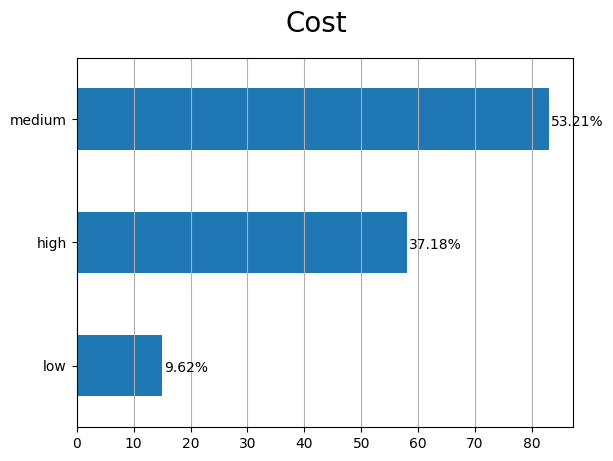

In [125]:
x = "Cost"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.20,
    str(round((i.get_width()/total)* 100, 2))+ '%',
    fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()

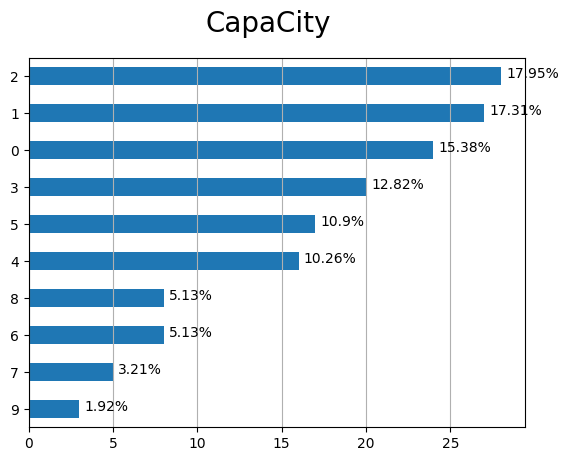

In [126]:
x = "CapaCity"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


Saat ini, hanya sebagian kecil toko yg beroprasi dengan potensi penuh(Kapasitas Kiri = 0), Artinya ada beberapa dengan staf yg sangat rendah(Kapasitas Kiri tinggi)

Mari kita visualisasikan potongan-potongan informasi itu di peta. Pertama-tama, Kita perlu mendapatkan koordinat area geografis untuk memulai peta. Kita akan melakukannya dengan geopy:

In [127]:
city = "Las Vegas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States
[lat, long]: [36.1672559, -115.148516]


Kita akan membuat peta dengan folium, package yang sangat nyaman yang memungkinkan kita untuk memplot peta interaktif tanpa perlu memuat shapefile. Setiap toko harus diidentifikasi dengan titik dengan ukuran proporsional dengan staf saat ini dan warna berdasarkan biayanya. Kita juga akan menambahkan sepotong kecil kode HTML ke peta default untuk menampilkan legenda.

In [128]:
x, y = "Latitude", "Longitude"
color = "Cost"
size = "Staff"
popup = "Street Address"
data = dtf.copy()

## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(dtf[color].unique()))
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

Tujuan kita adalah untuk menutup sebanyak mungkin toko berbiaya tinggi (titik merah) dengan memindahkan staf mereka ke toko berbiaya rendah (titik hijau) dengan kapasitas yang terletak di lingkungan yang sama. Akibatnya, kita akan memaksimalkan keuntungan (dengan menutup toko berbiaya tinggi) dan efisiensi (dengan memiliki toko berbiaya rendah yang bekerja dengan kapasitas penuh).

Bagaimana kita bisa mendefinisikan lingkungan tanpa memilih ambang jarak dan batas geografis? Nah, jawabannya adalah… Clustering.

# Model Building: Clustering and Evaluation

Di sini, untuk menentukan k yang tepat, Kita akan menggunakan Metode Siku: memplot varians sebagai fungsi dari jumlah cluster dan memilih k yang meratakan kurva.

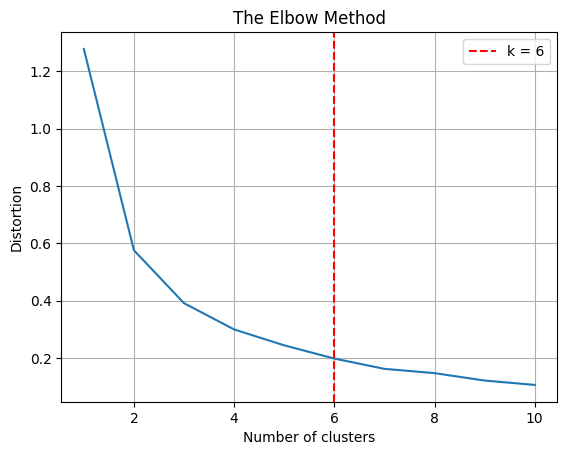

In [129]:
X = dtf[["Latitude","Longitude"]]
max_k = 10
## iterations
distortions = []
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters',
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

Kita dapat mencoba dengan k = 5 sehingga algoritma K-Means akan menemukan 5 centroid teoritis. Selain itu, Kita juga akan mengidentifikasi centroid sebenarnya (pengamatan terdekat dengan pusat cluster).

In [131]:
k = 6
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["Latitude","Longitude"]]
## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_,
                     dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-131-4a2cfe401f76>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtf_X["centroids"].iloc[i] = 1


,id,City,Street Address,Longitude,Latitude,Potential,Staff,CapaCity,Cost,cluster,centroids,controids,Capacity
25,25,Las Vegas,2211 N Rampart Blvd,-115.28,36.20,8,3,6,medium,4,0,0,5
60,60,Las Vegas,4100 Blue Diamond Rd,-115.20,36.04,10,5,4,medium,1,0,0,5
88,88,Las Vegas,4055 South Durango Drive,-115.28,36.12,5,1,1,low,2,0,0,4
85,85,Las Vegas,1940 Village Center Cir,-115.31,36.19,5,3,5,medium,4,0,0,2
32,32,Las Vegas,3545 Las Vegas Blvd S,-115.17,36.12,7,6,4,high,3,0,0,1


Kita menambahkan dua kolom ke dataset: "cluster" yang menunjukkan cluster apa yang menjadi milik observasi, dan "centroids" yaitu 1 jika pengamatan juga merupakan centroid (paling dekat dengan pusat) dan 0 sebaliknya. Mari kita rencanakan:

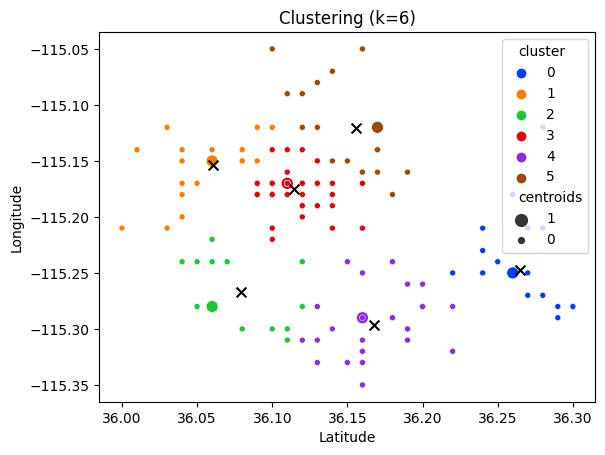

In [132]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf,
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black',
           marker="x")

Terlepas dari algoritma yang Anda gunakan untuk mengelompokkan data, sekarang Anda memiliki kumpulan data dengan dua kolom lagi (“cluster”, “centroids”). Kita dapat menggunakannya untuk memvisualisasikan cluster pada peta, dan kali ini kita akan menampilkan centroid juga menggunakan marker.

In [133]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf.copy()
# create color colum
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
# create size column (scaled)
scaled = preprocessing.MinMaxScaler(feature_range=(3, 15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

# initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
# add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
# add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
  legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
# add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row:
                             folium.Marker(location=[row[x],row[y]],
                             popup=row[marker], draggable=False,
                             icon=folium.Icon(color="black")).add_to(map_), axis=1)
# plot the map
map_

# x, y = "Latitude", "Longitude"
# color = "cluster"
# size = "Staff"
# popup = "Street Address"
# marker = "centroids"
# data = dtf.copy()
# ## create color column
# lst_elements = sorted(list(dtf[color].unique()))
# lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in
#               range(len(lst_elements))]
# data["color"] = data[color].apply(lambda x:
#                 lst_colors[lst_elements.index(x)])
# ## create size column (scaled)
# scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
# data["size"] = scaler.fit_transform(
#                data[size].values.reshape(-1,1)).reshape(-1)
# ## initialize the map with the starting location
# map_ = folium.Map(location=location, tiles="cartodbpositron",
#                   zoom_start=11)
# ## add points
# data.apply(lambda row: folium.CircleMarker(
#            location=[row[x],row[y]], popup=row[popup],
#            color=row["color"], fill=True,
#            radius=row["size"]).add_to(map_), axis=1)

# legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
# for i in lst_elements:
#      legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
#      fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
#      </i>&nbsp;"""+str(i)+"""<br>"""
# legend_html = legend_html+"""</div>"""
# map_.get_root().html.add_child(folium.Element(legend_html))
# ## add centroids marker
# lst_elements = sorted(list(dtf[marker].unique()))
# data[data[marker]==1].apply(lambda row:
#            folium.Marker(location=[row[x],row[y]],
#            popup=row[marker], draggable=False,
#            icon=folium.Icon(color="black")).add_to(map_), axis=1)
# ## plot the map
# map_

Sekarang kita memiliki cluster, kita dapat memulai rasionalisasi toko di dalam masing-masing cluster.

# Store Rationalization

Karena fokus utama artikel ini adalah mengelompokkan data geospasial, Kita akan membuat bagian ini tetap sederhana. Di dalam setiap cluster, Kita akan memilih target potensial (toko berbiaya tinggi) dan hub (toko berbiaya rendah), dan merelokasi staf target di hub sampai yang terakhir mencapai kapasitas penuh. Ketika seluruh staf target dipindahkan, toko bisa ditutup.

In [134]:
dtf_new = pd.DataFrame()
for c in sorted(dtf["cluster"].unique()):
    dtf_cluster = dtf[dtf["cluster"]==c]

    ## hubs and targets
    lst_hubs = dtf_cluster[dtf_cluster["Cost"]=="low"
               ].sort_values("CapaCity").to_dict("records")
    lst_targets = dtf_cluster[dtf_cluster["Cost"]=="high"
               ].sort_values("Staff").to_dict("records")
    ## move targets
    for target in lst_targets:
         for hub in lst_hubs:
             ### if hub has space
             if hub["CapaCity"] > 0:
                residuals = hub["CapaCity"] - target["Staff"]
                #### case of hub has still capacity: do next target
                if residuals >= 0:
                   hub["Staff"] += target["Staff"]
                   hub["CapaCity"] = hub["Potential"] - hub["Staff"]
                   target["CapaCity"] = target["Potential"]
                   target["Staff"] = 0
                   break
                #### case of hub is full: do next hub
                else:
                   hub["CapaCity"] = 0
                   hub["Staff"] = hub["Potential"]
                   target["Staff"] = -residuals
                   target["CapaCity"] = target["Potential"] - target["Staff"]
    dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
                 ).append(pd.DataFrame(lst_targets))
dtf_new = dtf_new.append(dtf[dtf["Cost"]=="medium"]
                 ).reset_index(drop=True).sort_values(
                 ["cluster","Staff"])
dtf_new.head()

<ipython-input-134-86aa8301d4c0>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
<ipython-input-134-86aa8301d4c0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ).append(pd.DataFrame(lst_targets))
<ipython-input-134-86aa8301d4c0>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dtf_new = dtf_new.append(pd.DataFrame(lst_hubs)
<ipython-input-134-86aa8301d4c0>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ).append(pd.DataFrame(lst_targets))
<ipython-input-134-86aa8301d4c0>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. U

,id,City,Street Address,Longitude,Latitude,Potential,Staff,CapaCity,Cost,cluster,centroids,controids,Capacity
1,46,Las Vegas,7151 W Craig Rd,-115.25,36.24,10,0,10,high,0,0,0,9
2,152,Las Vegas,4850 West Craig Road,-115.21,36.24,5,1,2,high,0,0,0,4
81,24,Las Vegas,"7220 West Azure Drive, #110",-115.25,36.27,5,1,3,medium,0,0,0,4
149,141,Las Vegas,7075 W Ann Rd,-115.25,36.26,3,1,5,medium,0,1,1,2
3,66,Las Vegas,8410 Farm Road,-115.28,36.30,7,2,4,high,0,0,0,5


In [136]:
dtf_new.shape

(156, 13)

In [137]:
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1
                                           if x==0 else 0)
print("closed:", dtf_new["closed"].sum())

closed: 22


In [139]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf_new.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row:
           folium.Marker(location=[row[x],row[y]],
           popup=row[marker], draggable=False,
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_